<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Identificardor_de_Parametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

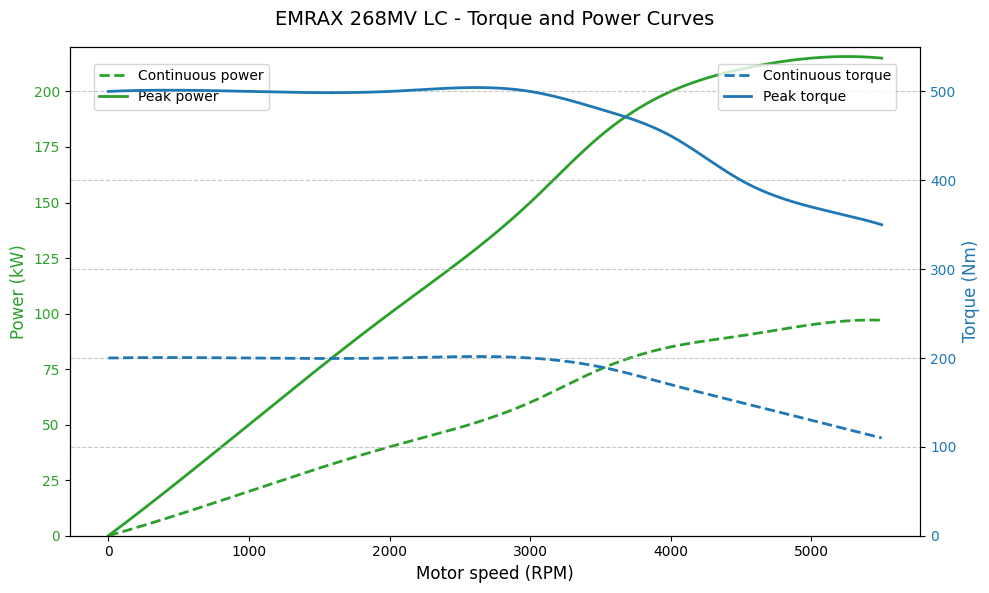

In [2]:
# @title Estimação de curva EMRAX268 - Escalas Invertidas
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Dados de RPM e valores característicos
rpm = np.array([0, 1000, 2000, 3000, 3500, 4000, 4500, 5000, 5500])

# Valores de potência (escala à esquerda)
potencia_continua = np.array([0, 20, 40, 60, 75, 85, 90, 95, 97])
potencia_pico = np.array([0, 50, 100, 150, 180, 200, 210, 215, 215])

# Valores de torque (escala à direita)
torque_continuo = np.array([200, 200, 200, 200, 190, 170, 150, 130, 110])
torque_pico = np.array([500, 500, 500, 500, 480, 450, 400, 370, 350])

# Interpolação suavizada
rpm_interp = np.linspace(0, 5500, 1000)
torque_continuo_interp = interp1d(rpm, torque_continuo, kind='cubic')(rpm_interp)
torque_pico_interp = interp1d(rpm, torque_pico, kind='cubic')(rpm_interp)
potencia_continua_interp = interp1d(rpm, potencia_continua, kind='cubic')(rpm_interp)
potencia_pico_interp = interp1d(rpm, potencia_pico, kind='cubic')(rpm_interp)

# Configuração do gráfico com escalas invertidas
fig, ax1 = plt.subplots(figsize=(10, 6))

# Curvas de Potência (eixo Y esquerdo)
ax1.set_xlabel('Motor speed (RPM)', fontsize=12)
ax1.set_ylabel('Power (kW)', color='tab:green', fontsize=12)
ax1.plot(rpm_interp, potencia_continua_interp, label='Continuous power', color='tab:green', linestyle='--', linewidth=2)
ax1.plot(rpm_interp, potencia_pico_interp, label='Peak power', color='tab:green', linewidth=2)
ax1.set_ylim(0, 220)
ax1.tick_params(axis='y', labelcolor='tab:green')

# Curvas de Torque (eixo Y direito)
ax2 = ax1.twinx()
ax2.set_ylabel('Torque (Nm)', color='tab:blue', fontsize=12)
ax2.plot(rpm_interp, torque_continuo_interp, label='Continuous torque', color='tab:blue', linestyle='--', linewidth=2)
ax2.plot(rpm_interp, torque_pico_interp, label='Peak torque', color='tab:blue', linewidth=2)
ax2.set_ylim(0, 550)
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Formatação final
fig.suptitle('EMRAX 268MV LC - Torque and Power Curves', fontsize=14)
ax1.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98))
ax2.legend(loc="upper right", bbox_to_anchor=(0.98, 0.98))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

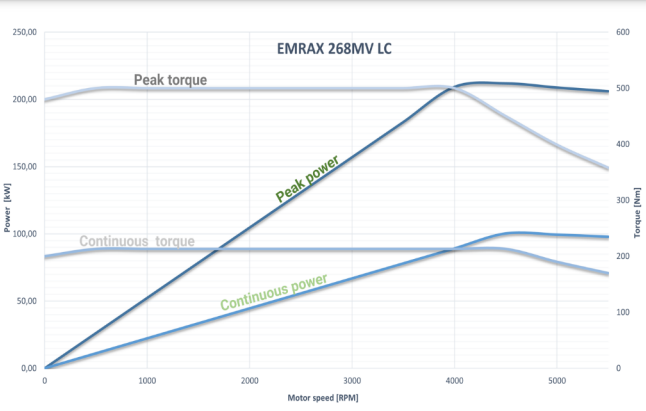

In [3]:
import numpy as np
import plotly.graph_objects as go

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K, fe):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona
        self.fe = fe  # Frequência de entrada

    def set_frequencia(self, frequencia):
        """Atualiza a frequência e recalcula a velocidade síncrona."""
        self.frequencia = frequencia
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)
        return Z1 ,Z1 + Z2_prime

    def calcular_corrente(self, V_fase, s):
        Z = self.calcular_impedancia(s)[1]
        return V_fase / Z

    def calcular_tensao_induzida(self, V_fase, s):
        E2 = V_fase - self.calcular_corrente(V_fase, s) * self.calcular_impedancia(s)[0]
        return E2

    def calcular_torque(self, V_fase, s):
       # Corrente do rotor
        E2 = self.calcular_tensao_induzida(V_fase, s)
        I2 = np.abs(E2 / (self.R2 / s + complex(0, self.X2)))
        P_r = 3 * I2**2 * (self.R2 / s)

        if self.frequencia <= self.fe:
            w_s_nominal = 2 * np.pi * self.fe / (self.P / 2)
            return self.K * P_r / w_s_nominal
        else:
            return self.K * P_r / self.w_s

    def simular_malha(self, V_fase, escorregamentos, freq_min=1, freq_max=120, passo=0.121):
        """Gera uma malha de torque para uma faixa de frequências e escorregamentos."""
        frequencias = np.arange(freq_min, freq_max + 1, passo)
        escorregamentos = np.array(escorregamentos)
        torques = np.zeros((len(frequencias), len(escorregamentos)))

        for i, freq in enumerate(frequencias):
            self.set_frequencia(freq)
            torques[i, :] = [self.calcular_torque(V_fase, s) for s in escorregamentos]

        return frequencias, escorregamentos, torques

    def plotar_superficie_torque(self, V_fase, escorregamentos,Polos, freq_min=12, freq_max=120, passo=0.121):
        """Plota o gráfico de superfície interativo usando Plotly, com RPM e linhas para torque nominal e máximo."""
        # Simular a malha de torques
        frequencias, escorreg, torques = self.simular_malha(V_fase, escorregamentos, freq_min, freq_max, passo)

        # Converter frequências para RPM
        rpm = (120 * frequencias) / Polos  # Fórmula para RPM


        s_nominal = 0.03
        # Determinar o torque nominal (s = 0.07)
        idx_nominal = np.where(np.isclose(escorreg, s_nominal, atol=0.0001))[0]
        if len(idx_nominal) > 0:
            torque_nominal = torques[:, idx_nominal[0]]  # Coluna associada ao escorregamento nominal
        else:
            torque_nominal = None
            print(f"Escorregamento nominal ({s_nominal}) não encontrado na lista de escorregamentos.")


        # Determinar o torque máximo
        torques_maximos = [max(torques[i]) for i in range(len(frequencias))]
        s_maximos = [escorreg[torques[i].argmax()] for i in range(len(frequencias))]  # Escorregamento associado ao torque máximo

        # Calcular a potência para o torque nominal e máximo
        pn = [torque_nominal[i] * (2 * np.pi * frequencias[i] / (Polos/2)) for i in range(len(frequencias))]
        pmax = [torques_maximos[i] * (2 * np.pi * frequencias[i] / (Polos/2)) for i in range(len(frequencias))]  # Potência máxima


        # Criar o gráfico 3D
        fig = go.Figure()

        # Superfície 3D
        fig.add_trace(go.Surface(
            x=escorreg,  # Escorregamento no eixo X
            y=rpm,  # RPM no eixo Y
            z=torques,  # Torque no eixo Z
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title="Torque (Nm)")
        ))

        # Adicionar linha para torque nominal (se encontrada)
        if torque_nominal is not None:
            fig.add_trace(go.Scatter3d(
                x=[s_nominal] * len(frequencias),  # Escorregamento fixo
                y=rpm,  # RPM
                z=torque_nominal,  # Torque nominal
                mode='lines',
                line=dict(color='red', width=4),
                name=f"Nominal Torque ({s_nominal})",
            ))


        # Adicionar linha para torque máximo
        fig.add_trace(go.Scatter3d(
            x=s_maximos,  # Escorregamentos associados ao torque máximo
            y=rpm,  # RPM
            z=torques_maximos,  # Torque máximo
            mode='lines',
            line=dict(color='blue', width=4),
            name="Max Torque"
        ))

        # Configurações do layout

        fig.update_layout(
            title="Torque vs Slip vs RPM Surface",
            scene=dict(
                xaxis_title="Slip",
                yaxis_title="RPM",
                zaxis_title="Torque (Nm)",
                yaxis=dict(autorange="reversed")  # Invertendo o eixo de frequência
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=0, r=0, b=0, t=40),width=800, height=600
        )

        #fig.show()

        # Criando o gráfico de potência com duas escalas
        fig1 = go.Figure()

        # Potência nominal
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=pn,
            mode='lines',
            line=dict(color='red', width=4),
            name=f"Nominal Power (Pn)"
        ))

        # Potência máxima
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=pmax,
            mode='lines',
            line=dict(color='red', width=4, dash='dash'),
            name=f"Max Power"
        ))
        #torque nominal
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=torque_nominal,
            mode='lines',
            line=dict(color='blue', width=4),
            name=f"Nominal Torque ",
            yaxis='y2'
        ))
        #torque máximo
        fig1.add_trace(go.Scatter(
            x=rpm,  # RPM no eixo X
            y=torques_maximos,
            mode='lines',
            line=dict(color='blue', width=4, dash='dash'),
            name=f"Max Torque",
            yaxis='y2'
        ))

        # Adicionando a segunda escala (para o torque)
        fig1.update_layout(
            title="Power vs Torque",
            xaxis=dict(
                title="RPM",
                showgrid=False
            ),
            yaxis=dict(
                title="Power (kW)",
                titlefont=dict(color='red'),
                tickfont=dict(color='red'),
                side='left'
            ),
            yaxis2=dict(
                title="Torque (Nm)",
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue'),
                overlaying='y',
                side='right'
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            margin=dict(l=0, r=0, b=0, t=40),width=800, height=600
        )

        #fig1.show()
        return torque_nominal






# Parâmetros iniciais do motor
frequencia = 60  # Frequência inicial em Hz
P = 4  # Número de polos
R1 = 0.2 # Resistência do estator
X1 = 3   # Reatância do estator
R2 = 1.3 # Resistência do rotor
X2 = 2  # Reatância do rotor
Xm = 28  # Reatância magnética
K = 1  # Constante de proporcionalidade
fe= 60


motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K,fe)

# Simulação
V_fase = 220 / np.sqrt(3)  # Tensão de fase
escorregamentos = np.linspace(0.001, 1, 1000)  # Escorregamento de 1% a 100%

motor.plotar_superficie_torque(V_fase, escorregamentos,P, freq_min=0.12, freq_max=120, passo=0.12)


array([4.74207296, 4.74207296, 4.74207296, ..., 2.35689511, 2.3545546 ,
       2.35221873])

In [7]:
# @title Identificação e análise de parâmetros

import matplotlib.pyplot as plt
import scipy.optimize as opt


def calcular_erro(params, V_fase, s, torque_experimental):
    R1, X1, R2, X2, Xm = params
    motor.R1, motor.X1, motor.R2, motor.X2, motor.Xm = R1, X1, R2, X2, Xm
    torque_simulado = motor.plotar_superficie_torque(V_fase, s, P, freq_min=0.12, freq_max=120, passo=0.12)[0]
    erro_total = np.sum((torque_simulado - torque_experimental) ** 2)
    return erro_total

# Função de erro total
def total_error(params, motor, V_fase, escorregamento, torque_experimental):
    return calcular_erro(params, V_fase, escorregamento, torque_experimental)

# Dados experimentais de torque para escorregamento
escorregamentos = np.linspace(0.001, 1, 1000)  # Escorregamentos simulados
torques_experimentais = torque_continuo_interp  # Dados de torque (substitua pelos dados reais)

torque_experimental = torques_experimentais[::-1]

# Instanciando o motor com valores iniciais
motor = MotorDeGaiola(frequencia=50, P=4, R1=0.1, X1=0.2, R2=0.1, X2=0.2, Xm=5, K=0.95,fe=60)

# Parâmetros a serem otimizados: [R1, X1, R2, X2, Xm]
parametros_iniciais = [0.1, 0.2, 0.1, 0.2, 5]
param_bounds = [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 10), (0.1, 300)]

# Função de otimização
result = opt.minimize(total_error, parametros_iniciais, args=(motor, 220, escorregamentos, torque_experimental), bounds=param_bounds)

# Imprimindo parâmetros otimizados
parametros_otimizados = result.x
print(f"Parâmetros otimizados: {parametros_otimizados}")

R1_otimizado, X1_otimizado, R2_otimizado, X2_otimizado, Xm_otimizado = parametros_otimizados

#motorID= MotorDeGaiola(frequencia=60, P=4, R1_otimizado, X1_otimizado , R2_otimizado, X2_otimizado, Xm_otimizado, K=0.95 , fe = 150)

# Comparando torque simulado com experimental
torques_simulados = [motorID.plotar_superficie_torque(V_fase, s, P, freq_min=0.12, freq_max=120, passo=0.12)[0]]

# Convertendo escorregamento para RPM
rpm_simulados = motor.w_s * (1 - escorregamentos)

plt.plot(rpm_simulados, torques_simulados, label='Torque Simulado')
#plt.scatter(rpm_simulados, torques_experimentais, color='red', label='Torque Experimental')
plt.scatter(rpm_simulados, torque_experimental, color='green', label='Torque Experimental')
plt.xlabel('RPM')
plt.ylabel('Torque (Nm)')
plt.title('Torque Simulado vs Experimental em função do RPM')
plt.legend()
plt.grid(True)
plt.show()


Parâmetros otimizados: [0.10426602 0.20422135 0.10426707 0.20422296 4.99788871]


NameError: name 'motorID' is not defined

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import scipy.optimize as opt


def interpolar_curvas(rpm, valores, num_pontos=1000, kind='cubic'):
    """
    Interpola suavemente um conjunto de pontos.
    """
    rpm_interp = np.linspace(rpm.min(), rpm.max(), num_pontos)
    f = interp1d(rpm, valores, kind=kind)
    return rpm_interp, f(rpm_interp)


def plot_torque_power_curves(rpm, cont_power, peak_power, cont_torque, peak_torque):
    """
    Plota curvas de potência e torque com eixos Y duplos.
    """
    rpm_i, pc_i = interpolar_curvas(rpm, cont_power)
    _, pp_i = interpolar_curvas(rpm, peak_power)
    _, tc_i = interpolar_curvas(rpm, cont_torque)
    _, tp_i = interpolar_curvas(rpm, peak_torque)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('RPM')
    ax1.set_ylabel('Power (kW)', color='green')
    ax1.plot(rpm_i, pc_i, '--', label='Contínua', linewidth=2)
    ax1.plot(rpm_i, pp_i,     label='Pico',     linewidth=2)
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.set_ylim(0, max(peak_power)*1.1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Torque (Nm)', color='blue')
    ax2.plot(rpm_i, tc_i, '--', label='Contínuo', linewidth=2)
    ax2.plot(rpm_i, tp_i,     label='Pico',     linewidth=2)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, max(peak_torque)*1.1)

    fig.suptitle('Curvas de Torque e Potência')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


class MotorDeGaiola:
    """
    Modelo de motor de indução (gaiola de esquilo).
    """
    def __init__(self, frequencia, polos, R1, X1, R2, X2, Xm, K):
        self.f = frequencia
        self.polos = polos
        self.R1, self.X1 = R1, X1
        self.R2, self.X2 = R2, X2
        self.Xm = Xm
        self.K = K
        self._update_sync_speed()

    def _update_sync_speed(self):
        self.omega_sync = 2 * np.pi * self.f / (self.polos / 2)

    def set_frequencia(self, f):
        self.f = f
        self._update_sync_speed()

    def _impedancias(self, s):
        j = 1j
        Z1 = self.R1 + j*self.X1
        Z2 = self.R2/s + j*self.X2
        Zm = j*self.Xm
        Z2p = (Z2*Zm)/(Z2+Zm)
        return Z1, Z1 + Z2p

    def torque(self, Vfase, s):
        Z1, Ztot = self._impedancias(s)
        I1 = Vfase / Ztot
        E2 = Vfase - I1*Z1
        I2 = np.abs(E2 / (self.R2/s + 1j*self.X2))
        Pr = 3 * I2**2 * (self.R2/s)
        return self.K * Pr / self.omega_sync

    def gerar_malha(self, Vfase, slips, f_min, f_max, passo):
        freqs = np.arange(f_min, f_max+passo, passo)
        slips = np.array(slips)
        T = np.zeros((len(freqs), len(slips)))
        for i, f in enumerate(freqs):
            self.set_frequencia(f)
            T[i,:] = [self.torque(Vfase, s) for s in slips]
        return freqs, slips, T

    def plot_superficie(self, Vfase, slips, polos, f_min=1, f_max=120, passo=0.5):
        freqs, slips, T = self.gerar_malha(Vfase, slips, f_min, f_max, passo)
        rpm = 120 * freqs / polos

        # Curva nominal e máxima
        s_nom = 0.03
        idx_nom = np.argmin(np.abs(slips - s_nom))
        T_nom = T[:, idx_nom]
        T_max = T.max(axis=1)
        s_max = slips[T.argmax(axis=1)]
        P_nom = T_nom * (2*np.pi*freqs/(polos/2))
        P_max = T_max * (2*np.pi*freqs/(polos/2))

        # 3D
        fig = go.Figure()
        fig.add_trace(go.Surface(x=slips, y=rpm, z=T, opacity=0.8, colorbar=dict(title='Torque')))
        fig.add_trace(go.Scatter3d(x=[s_nom]*len(rpm), y=rpm, z=T_nom,
                                   mode='lines', line=dict(color='red', width=4),
                                   name='Torque Nominal'))
        fig.add_trace(go.Scatter3d(x=s_max, y=rpm, z=T_max,
                                   mode='lines', line=dict(color='blue', width=4),
                                   name='Torque Máximo'))
        fig.update_layout(scene=dict(xaxis_title='Slip', yaxis_title='RPM', zaxis_title='Torque'),
                          title='Superfície Torque vs Slip vs RPM',
                          width=800, height=600)
        fig.show()

        # 2D
        fig2 = go.Figure()
        fig2.add_trace(go.Scatter(x=rpm, y=P_nom,   mode='lines', name='P Nominal'))
        fig2.add_trace(go.Scatter(x=rpm, y=P_max,   mode='lines', name='P Máxima', line=dict(dash='dash')))
        fig2.add_trace(go.Scatter(x=rpm, y=T_nom,   mode='lines', name='T Nominal',   yaxis='y2'))
        fig2.add_trace(go.Scatter(x=rpm, y=T_max,   mode='lines', name='T Máximo',    yaxis='y2', line=dict(dash='dash')))
        fig2.update_layout(xaxis_title='RPM',
                           yaxis=dict(title='Potência (W)'),
                           yaxis2=dict(title='Torque (Nm)', overlaying='y', side='right'),
                           title='Potência vs Torque',
                           width=800, height=500)
        fig2.show()
        return T_nom, T_max


def otimizar_parametros(motor, Vfase, slips, torque_exp, bounds, iniciais):
    """
    Ajusta R1, X1, R2, X2, Xm para minimizar erro quadrático.
    """
    def erro(params):
        motor.R1, motor.X1, motor.R2, motor.X2, motor.Xm = params
        sim = np.array([motor.plot_superficie(Vfase, slips, polos=4, f_min=1, f_max=120, passo=0.5)[0]])
        return np.sum((sim - torque_exp)**2)

    result = opt.minimize(erro, iniciais, bounds=bounds)
    return result


if __name__ == '__main__':
    # Dados experimentais
    rpm = np.array([0,1000,2000,3000,3500,4000,4500,5000,5500])
    t_cont = np.array([200,200,200,200,190,170,150,130,110])

    # Malha de slips
    slips = np.linspace(0.001, 1, 200)
    # Curva experimental interpolada
    _, torque_exp = interpolar_curvas(rpm, t_cont, num_pontos=len(slips))

    # Configuração do motor e otimização
    motor = MotorDeGaiola(60, 4, 0.2, 3, 1.3, 2, 28, 1)
    bounds = [(0.01,10)]*4 + [(0.1,300)]
    iniciais = [0.1,0.2,0.1,0.2,5]
    res = otimizar_parametros(motor, 220/np.sqrt(3), slips, torque_exp, bounds, iniciais)
    print("Parâmetros otimizados:", res.x)

    # Gera curva simulada com parâmetros ótimos
    motor.R1, motor.X1, motor.R2, motor.X2, motor.Xm = res.x
    torque_sim = np.array([motor.plot_superficie(Vfase, slips, polos=4, f_min=1, f_max=120, passo=0.5)[0]])

    # Plot de comparação
    plt.figure(figsize=(8,5))
    plt.plot(rpm, t_cont, 'o', label='Experimental (pontos originais)')
    plt.plot(120*slips/4, torque_exp, '--', label='Experimental (interpolada)')
    plt.plot(120*slips/4, torque_sim,  '-', label='Simulada (ótimos)')
    plt.xlabel('RPM')
    plt.ylabel('Torque (Nm)')
    plt.title('Comparação: Curva Experimental vs Simulada')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


ValueError: operands could not be broadcast together with shapes (1,239) (200,) 